# EMTAB9816 - preprocessing
## Xiaonan Wang
## 31May2022

In [3]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

/nfs01data1/Groups/Wangxiaonan/programs/miniconda3/envs/scanpy171/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.7.1 anndata==0.7.8 umap==0.5.3 numpy==1.19.5 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.9.6


# Data in

In [2]:
FileDir = '/nfs01data1/Groups/Wangxiaonan/share/rev_MI/EMTAB9816'

In [4]:
meta = pd.read_csv('E-MTAB-9816.sdrf.txt', index_col=0, sep='\t')

In [5]:
# remove duplicates due to paired end sequencing R1,R2
meta = meta.drop_duplicates(subset=['Comment[ENA_SAMPLE]'])

In [26]:
meta.columns

Index(['Comment[ENA_SAMPLE]', 'Comment[BioSD_SAMPLE]',
       'Characteristics[organism]', 'Characteristics[strain]',
       'Characteristics[age]', 'Unit[time unit]',
       'Characteristics[developmental stage]', 'Characteristics[sex]',
       'Characteristics[genotype]', 'Characteristics[phenotype]',
       'Characteristics[organism part]', 'Characteristics[individual]',
       'Characteristics[disease]', 'Material Type', 'Protocol REF',
       'Protocol REF.1', 'Protocol REF.2', 'Extract Name',
       'Comment[LIBRARY_LAYOUT]', 'Comment[LIBRARY_SELECTION]',
       'Comment[LIBRARY_SOURCE]', 'Comment[LIBRARY_STRAND]',
       'Comment[LIBRARY_STRATEGY]', 'Comment[cdna read]',
       'Comment[cdna read offset]', 'Comment[cdna read size]',
       'Comment[cell barcode offset]', 'Comment[cell barcode read]',
       'Comment[cell barcode size]', 'Comment[end bias]',
       'Comment[input molecule]', 'Comment[library construction]',
       'Comment[primer]', 'Comment[sample barcode offset

In [6]:
meta1 = meta[['Characteristics[organism]', 'Characteristics[strain]', 'Characteristics[age]', 'Characteristics[developmental stage]', 'Characteristics[sex]','Characteristics[genotype]','Characteristics[phenotype]', 'Derived Array Data File.2','Factor Value[disease]', 'Factor Value[time]','Comment[ENA_RUN]','Characteristics[organism part]']]

In [7]:
meta1.columns = ['Organism', 'Strain', 'Age', 'Development_stage', 'Gender', 'Genotype', 'CellType', 'Filename','Condition','Day','ERR','Tissue']

In [8]:
meta1.head(2)

,Organism,Strain,Age,Development_stage,Gender,Genotype,CellType,Filename,Condition,Day,ERR,Tissue
Source Name,,,,,,,,,,,,
Sample 1,Mus musculus,Cdh5-CreERT2;mT/mG,12,adult,male,Cdh5-CreERT2/+; mT/mG,Cdh5 knockout,103471-001-001_features.tsv.gz,normal,0,ERR4898566,heart
Sample 2,Mus musculus,Cdh5-CreERT2;mT/mG,12,adult,male,Cdh5-CreERT2/+; mT/mG,Cdh5 knockout,103471-001-002_features.tsv.gz,myocardial infarction,1,ERR4898567,heart


In [9]:
meta1 = meta1.assign(StudyID = 'EMTAB9816')
meta1 = meta1.assign(Index=[x[:14] for x in meta1['Filename']])
meta1.drop('Filename', axis=1, inplace=True)

In [10]:
meta1

,Organism,Strain,Age,Development_stage,Gender,Genotype,CellType,Condition,Day,ERR,Tissue,StudyID,Index
Source Name,,,,,,,,,,,,,
Sample 1,Mus musculus,Cdh5-CreERT2;mT/mG,12,adult,male,Cdh5-CreERT2/+; mT/mG,Cdh5 knockout,normal,0,ERR4898566,heart,EMTAB9816,103471-001-001
Sample 2,Mus musculus,Cdh5-CreERT2;mT/mG,12,adult,male,Cdh5-CreERT2/+; mT/mG,Cdh5 knockout,myocardial infarction,1,ERR4898567,heart,EMTAB9816,103471-001-002
Sample 3,Mus musculus,Cdh5-CreERT2;mT/mG,12,adult,male,Cdh5-CreERT2/+; mT/mG,Cdh5 knockout,myocardial infarction,3,ERR4898568,heart,EMTAB9816,103471-001-003
Sample 4,Mus musculus,Cdh5-CreERT2;mT/mG,12,adult,male,Cdh5-CreERT2/+; mT/mG,Cdh5 knockout,myocardial infarction,7,ERR4898569,heart,EMTAB9816,103471-001-004
Sample 6,Mus musculus,Cdh5-CreERT2;mT/mG,12,adult,male,Cdh5-CreERT2/+; mT/mG,Cdh5 knockout,myocardial infarction,28,ERR4898570,heart,EMTAB9816,103548-001-001
Sample 8,Mus musculus,Cdh5-CreERT2;mT/mG,12,adult,male,mT/mG,wild type phenotype,normal,0,ERR4898571,heart,EMTAB9816,103548-001-004
Sample 5,Mus musculus,Cdh5-CreERT2;mT/mG,12,adult,male,Cdh5-CreERT2/+; mT/mG,Cdh5 knockout,myocardial infarction,14,ERR4898572,heart,EMTAB9816,103548-001-005


In [65]:
adata = []
for idx, row in meta1.iterrows():
    adata_sub = sc.read_10x_mtx(FileDir, prefix=row['Index']+'_', cache=True)
    adata_sub.obs['Organism'] = row['Organism']
    adata_sub.obs['Strain'] = row['Strain']
    adata_sub.obs['Age'] = row['Age']
    adata_sub.obs['Development_stage'] = row['Development_stage']
    adata_sub.obs['Gender'] = row['Gender']
    adata_sub.obs['Genotype'] = row['Genotype']
    adata_sub.obs['CellType'] = row['CellType']
    adata_sub.obs['Condition'] = row['Condition']
    adata_sub.obs['Day'] = row['Day']
    adata_sub.obs['ERR'] = row['ERR']
    adata_sub.obs['Tissue'] = row['Tissue']
    adata_sub.obs['StudyID'] = row['StudyID']
    adata_sub.obs['Index'] = row['Index']
    adata.append(adata_sub)
    del adata_sub

... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-EMTAB9816-103471-001-001_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-EMTAB9816-103471-001-002_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-EMTAB9816-103471-001-003_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-EMTAB9816-103471-001-004_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-EMTAB9816-103548-001-001_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-EMTAB9816-103548-001-004_matrix.h5ad
... reading from cache file cache/nfs01data1-Groups-Wangxiaonan-share-rev_MI-EMTAB9816-103548-001-005_matrix.h5ad


# Doublet removal

In [66]:
import scrublet as scr

In [67]:
scrub_obj = []
for i in range(len(adata)):
    scrub = scr.Scrublet(adata[i].X.toarray())
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata[i].obs['db_scores'] = doublet_scores
    adata[i].obs['predicted_db'] = predicted_doublets
    scrub_obj.append(scrub)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.44
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 25.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.7%
Elapsed time: 4.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.56
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 11.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 27.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.8%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating double

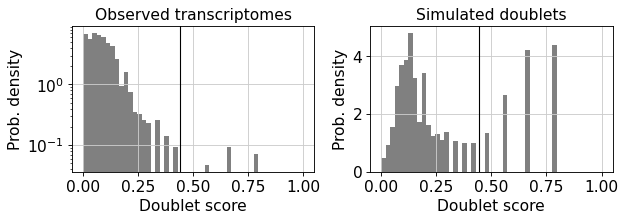

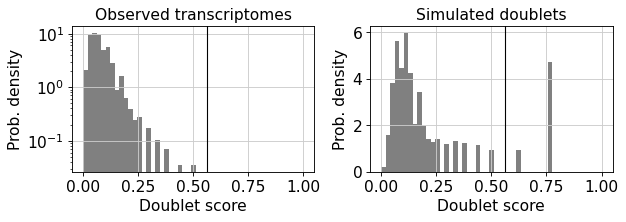

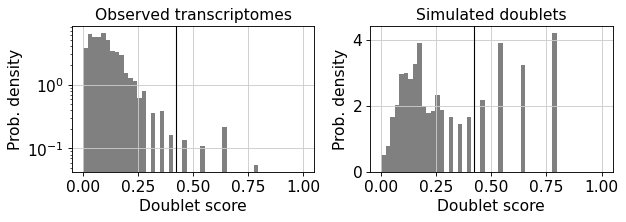

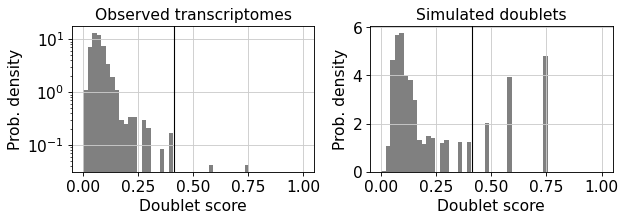

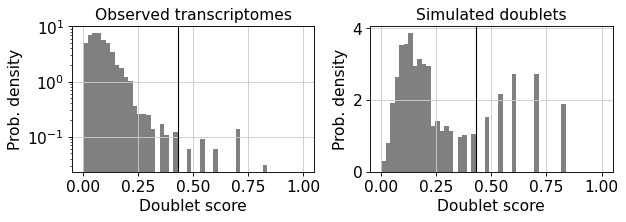

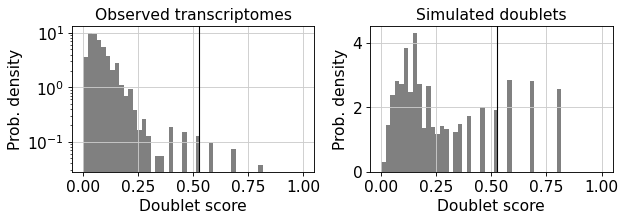

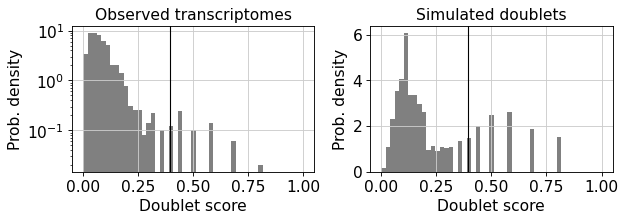

In [68]:
for i in range(len(adata)):
    scrub_obj[i].plot_histogram()

In [69]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

112
['normal: Number of doublets = 9']
20
['myocardial infarction: Number of doublets = 0']
104
['myocardial infarction: Number of doublets = 19']
36
['myocardial infarction: Number of doublets = 2']
200
['myocardial infarction: Number of doublets = 25']
143
['normal: Number of doublets = 11']
102
['myocardial infarction: Number of doublets = 34']


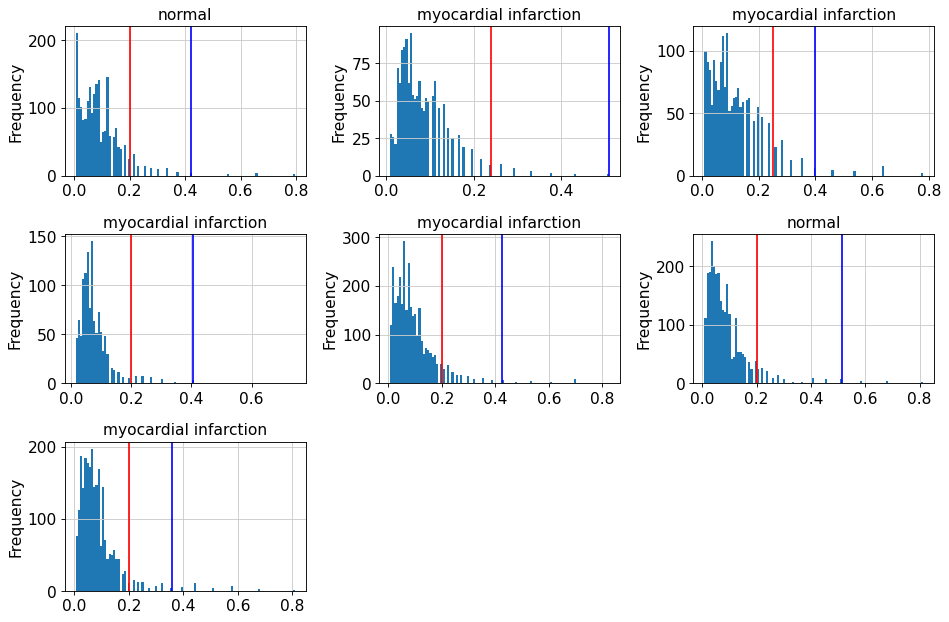

In [73]:
cutoffs = [0.2, 0.24, 0.25, 0.2, 0.2, 0.2, 0.2]

fig, ax = plt.subplots(3,3, figsize=(12,8))
ax = ax.flatten()
ax = trim_axs(ax, len(adata))
for i in range(len(adata)):    
    pd.DataFrame(adata[i].obs['db_scores']).plot.hist(bins=100, ax=ax[i])
    ax[i].axvline(x=cutoffs[i], color='r')
    ax[i].axvline(x=np.sort(adata[i].obs['db_scores'])[::-1][np.sum(adata[i].obs['predicted_db'])], color='b')
    ax[i].get_legend().remove()
    ax[i].set_title(adata[i].obs['Condition'][0])
    print(np.sum(adata[i].obs['db_scores'] > cutoffs[i]))
    print(np.unique(adata[i].obs['Condition'])+': Number of doublets = '+str(np.sum(adata[i].obs['predicted_db'])))
plt.tight_layout()  

In [74]:
for i in range(len(adata)):
    adata[i].obs['predicted_db'] = adata[i].obs['db_scores'] > cutoffs[i]

In [75]:
# remove doublets
for i in range(len(adata)):
    print(np.unique(adata[i].obs['Condition'])+str(adata[i].shape))
    adata[i] = adata[i][~adata[i].obs['predicted_db'],:].copy()
    print(np.unique(adata[i].obs['Condition'])+str(adata[i].shape))

['normal(2096, 28002)']
['normal(1984, 28002)']
['myocardial infarction(1405, 28002)']
['myocardial infarction(1385, 28002)']
['myocardial infarction(1791, 28002)']
['myocardial infarction(1687, 28002)']
['myocardial infarction(1176, 28002)']
['myocardial infarction(1140, 28002)']
['myocardial infarction(3213, 28002)']
['myocardial infarction(3013, 28002)']
['normal(2630, 28002)']
['normal(2487, 28002)']
['myocardial infarction(2446, 28002)']
['myocardial infarction(2344, 28002)']


# QC

In [76]:
[x for x in adata[0].var_names if 'mt-' in x]

['mt-Nd1',
 'mt-Nd2',
 'mt-Co1',
 'mt-Co2',
 'mt-Atp8',
 'mt-Atp6',
 'mt-Co3',
 'mt-Nd3',
 'mt-Nd4l',
 'mt-Nd4',
 'mt-Nd5',
 'mt-Nd6',
 'mt-Cytb']

In [77]:
for i in range(len(adata)):
    adata[i].var['mt'] = adata[i].var_names.str.startswith('mt-') 
    sc.pp.calculate_qc_metrics(adata[i], qc_vars=['mt'], inplace=True)

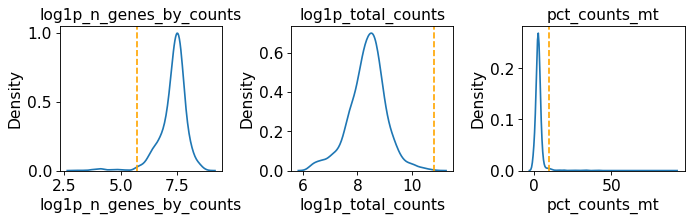

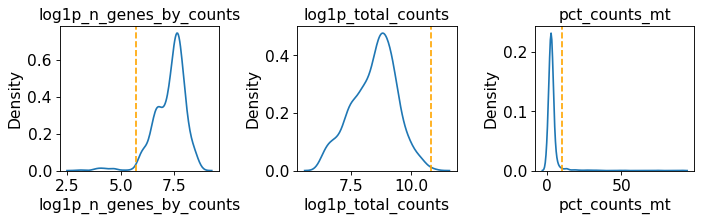

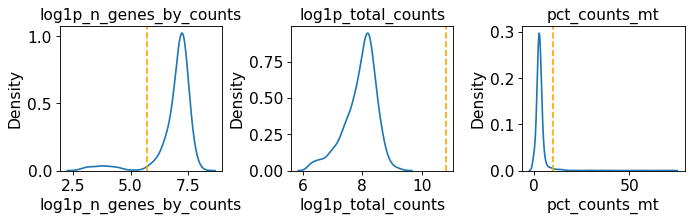

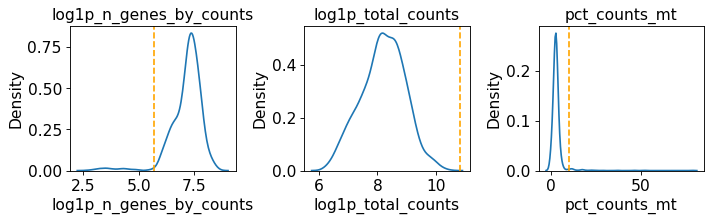

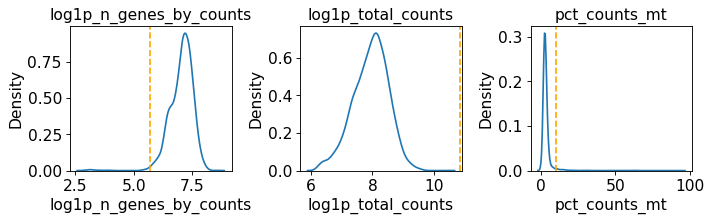

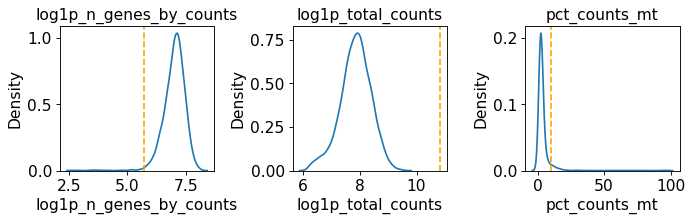

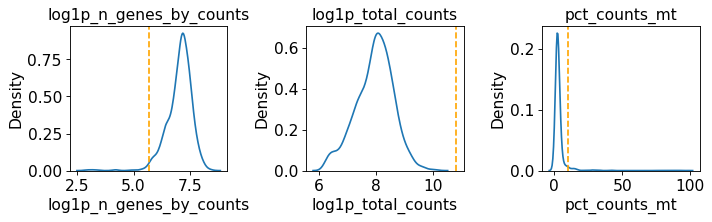

In [81]:
cutoffs = [[300,50000, np.exp(10)],
           [300,50000, np.exp(10)],
           [300,50000, np.exp(10)],
           [300,50000, np.exp(10)],
           [300,50000, np.exp(10)],
           [300,50000, np.exp(10)],
           [300,50000, np.exp(10)]]
for i in range(len(adata)):
    obs_terms = ['log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt']
    fig,ax = plt.subplots(1,3, figsize=(9,3))
    for j in range(len(obs_terms)):
        sns.kdeplot(adata[i].obs[obs_terms[j]], ax=ax[j])
        ax[j].grid(False)
        ax[j].set_title(obs_terms[j])
        ax[j].axvline(np.log1p(cutoffs[i][j]), c='orange', linestyle='--')
    plt.tight_layout()

In [82]:
for i in range(len(adata)):
    sc.pp.filter_cells(adata[i], min_genes=cutoffs[i][0])
    #sc.pp.filter_genes(adata[i], min_cells=1)
    adata[i] = adata[i][(adata[i].obs['total_counts'] <= cutoffs[i][1]) & (adata[i].obs['pct_counts_mt'] <= np.log(cutoffs[i][2])), :].copy()
    print(adata[i].obs['Condition'].value_counts().sort_index())

filtered out 33 cells that have less than 300 genes expressed
filtered out 24 cells that have less than 300 genes expressed
filtered out 101 cells that have less than 300 genes expressed
filtered out 29 cells that have less than 300 genes expressed
filtered out 23 cells that have less than 300 genes expressed


normal    1916
Name: Condition, dtype: int64
myocardial infarction    1321
Name: Condition, dtype: int64
myocardial infarction    1552
Name: Condition, dtype: int64
myocardial infarction    1086
Name: Condition, dtype: int64


filtered out 19 cells that have less than 300 genes expressed
filtered out 31 cells that have less than 300 genes expressed


myocardial infarction    2924
Name: Condition, dtype: int64
normal    2351
Name: Condition, dtype: int64
myocardial infarction    2233
Name: Condition, dtype: int64


In [83]:
for i in range(len(adata)):
    print(adata[i].shape)

(1916, 28002)
(1321, 28002)
(1552, 28002)
(1086, 28002)
(2924, 28002)
(2351, 28002)
(2233, 28002)


In [84]:
#combine and save the raw counts
adata1 = anndata.AnnData.concatenate(*adata)

In [85]:
adata1.shape

(13383, 28002)

In [86]:
sc.pp.filter_genes(adata1, min_cells=1)

filtered out 8552 genes that are detected in less than 1 cells


In [88]:
adata1.write('./write/EMTAB9816_raw.h5ad')

# Normalisation

In [89]:
adata = sc.read('./write/EMTAB9816_raw.h5ad')

In [90]:
print(adata.shape)

(13383, 19450)


In [91]:
# normalisation
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [92]:
# log counts
sc.pp.log1p(adata)

In [93]:
adata.raw = adata

In [94]:
print(adata.shape)

(13383, 19450)


In [95]:
adata.write('./write/EMTAB9816_lognorm.h5ad')

# Cell Cycle Assignment

In [96]:
adata = sc.read('./write/EMTAB9816_lognorm.h5ad')

In [97]:
print(adata.shape)

(13383, 19450)


In [98]:
cell_cycle_genes = [x.strip()[0].upper()+x.strip()[1:].lower() for x in open('/nfs01data1/Groups/Wangxiaonan/Lab_members/Files/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

97


In [99]:
np.setdiff1d(cell_cycle_genes, adata.raw.var_names)

array(['Mlf1ip'], dtype='<U8')

In [100]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
print('Number of s_genes: '+str(len(s_genes)))
print('Number of g2m_genes: '+str(len(g2m_genes)))
print('Total number of cell cycle genes: '+str(len(cell_cycle_genes)))

Number of s_genes: 43
Number of g2m_genes: 54
Total number of cell cycle genes: 97


In [101]:
ERR = adata.obs['ERR'].cat.categories
print(ERR)

Index(['ERR4898566', 'ERR4898567', 'ERR4898568', 'ERR4898569', 'ERR4898570',
       'ERR4898571', 'ERR4898572'],
      dtype='object')


In [102]:
phase = []
for i in range(len(ERR)):
    adata_sub = adata[adata.obs['ERR'] == ERR[i]].copy()
    print(adata_sub.shape)
    sc.pp.scale(adata_sub)
    sc.tl.score_genes_cell_cycle(adata_sub, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=False)
    phase.append(adata_sub.obs[['phase', 'S_score', 'G2M_score']])

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(1916, 19450)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    814 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    859 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(1321, 19450)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    684 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    901 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(1552, 19450)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    815 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    825 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(1086, 19450)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    728 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    902 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(2924, 19450)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    900 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    900 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(2351, 19450)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    815 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    817 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


(2233, 19450)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    768 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    815 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


In [103]:
phase_pd = pd.concat(phase)

In [104]:
phase_pd.head()

,phase,S_score,G2M_score
AAACCTGAGTTATCGC-1-0,G1,-0.181094,-0.053037
AAACCTGTCCGCGGTA-1-0,S,0.358538,0.274067
AAACGGGAGAAACGAG-1-0,G2M,-0.162381,0.033503
AAACGGGAGGATGGAA-1-0,S,0.092549,0.091912
AAACGGGCACGAAACG-1-0,G1,-0.123382,-0.078268


In [105]:
print(phase_pd.shape)

(13383, 3)


In [106]:
phase_pd.to_csv('cell_cycle_results.txt')

# Select highly variable genes

In [108]:
adata = sc.read('./write/EMTAB9816_lognorm.h5ad')

In [109]:
cell_cycle_results = pd.read_csv('cell_cycle_results.txt', index_col=0)
adata.obs = pd.concat([adata.obs, cell_cycle_results], axis=1)

In [110]:
adata.obs.head(3)

,Organism,Strain,Age,Development_stage,Gender,Genotype,CellType,Condition,Day,ERR,...,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_genes,batch,n_counts,phase,S_score,G2M_score
AAACCTGAGTTATCGC-1-0,Mus musculus,Cdh5-CreERT2;mT/mG,12,adult,male,Cdh5-CreERT2/+; mT/mG,Cdh5 knockout,normal,0,ERR4898566,...,72.169733,175.0,5.170484,2.900713,1983,0,6033.0,G1,-0.181094,-0.053037
AAACCTGTCCGCGGTA-1-0,Mus musculus,Cdh5-CreERT2;mT/mG,12,adult,male,Cdh5-CreERT2/+; mT/mG,Cdh5 knockout,normal,0,ERR4898566,...,88.873934,89.0,4.499810,3.992822,748,0,2229.0,S,0.358538,0.274067
AAACGGGAGAAACGAG-1-0,Mus musculus,Cdh5-CreERT2;mT/mG,12,adult,male,Cdh5-CreERT2/+; mT/mG,Cdh5 knockout,normal,0,ERR4898566,...,70.507378,157.0,5.062595,3.173641,1807,0,4947.0,G2M,-0.162381,0.033503


In [111]:
# find highly variable genes
# parameters are mainly selected depends on user preference
sc.pp.highly_variable_genes(
    adata, min_mean=0.02, max_mean=3, min_disp=0.3, batch_key='batch', inplace=True)

extracting highly variable genes
... storing 'phase' as categorical
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


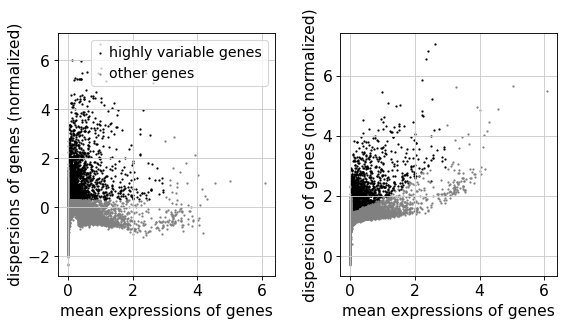

In [112]:
sc.pl.highly_variable_genes(adata)

In [113]:
print(np.sum(adata.var.highly_variable))

3172


In [114]:
adata = adata[:, adata.var.highly_variable].copy()

In [115]:
adata.write('./write/EMTAB9816_lognorm_hvg.h5ad')

# Preliminary processing

In [116]:
adata = sc.read('./write/EMTAB9816_lognorm_hvg.h5ad')

In [117]:
# normally regress out the top layers of unwanted effects
sc.pp.regress_out(adata, ['total_counts','n_genes_by_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:54)


In [118]:
# scale for pca
sc.pp.scale(adata)
# pca
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


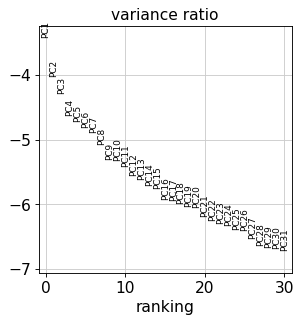

In [119]:
sc.pl.pca_variance_ratio(adata, log=True)

In [120]:
sc.pp.neighbors(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


In [121]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


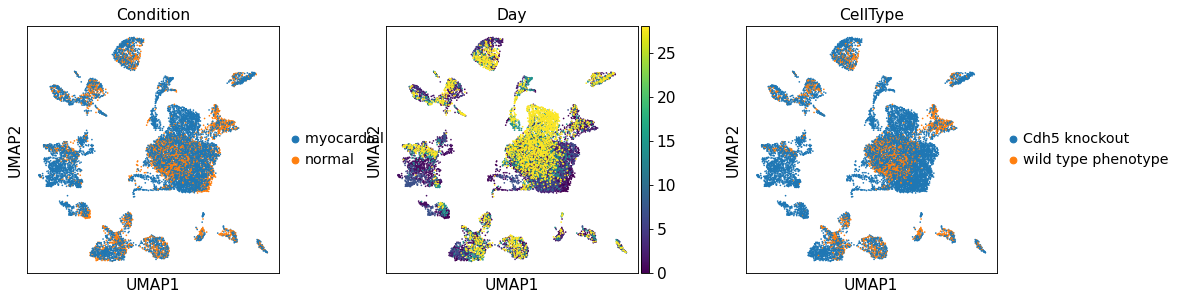

In [122]:
sc.pl.umap(adata, color= ['Condition', 'Day', 'CellType'], wspace=0.3)

In [123]:
adata.write('./write/EMTAB9816_processed.h5ad')

#  Further modify

In [1]:
adata = sc.read('./write/EMTAB9816_processed.h5ad')

NameError: name 'sc' is not defined

In [125]:
adata.obs['Day'].value_counts()

0     4267
28    2924
14    2233
3     1552
1     1321
7     1086
Name: Day, dtype: int64

In [136]:
adata.obs['Day'] = adata.obs['Day'].astype(int)

In [127]:
adata.obs['Age'].value_counts()

12    13383
Name: Age, dtype: int64

In [137]:
adata.obs['Age'] = adata.obs['Age'].astype(int)

In [129]:
adata.obs['Development_stage'].value_counts()

adult    13383
Name: Development_stage, dtype: int64

In [130]:
adata.obs['Genotype'].value_counts()

Cdh5-CreERT2/+; mT/mG    11032
mT/mG                     2351
Name: Genotype, dtype: int64

In [132]:
pd.crosstab(adata.obs['Genotype'], adata.obs['CellType'])

CellType,Cdh5 knockout,wild type phenotype
Genotype,,
Cdh5-CreERT2/+; mT/mG,11032,0
mT/mG,0,2351


In [138]:
adata.obs['Genotype'] = [x if 'Cdh5' in x else 'WT' for x in adata.obs['Genotype']]

In [139]:
adata.obs['Genotype'].value_counts()

Cdh5-CreERT2/+; mT/mG    11032
WT                        2351
Name: Genotype, dtype: int64

In [140]:
adata.obs['CellType'].value_counts()

Cdh5 knockout          11032
wild type phenotype     2351
Name: CellType, dtype: int64

In [141]:
adata.obs['CellType'] = 'Non-CM'

In [142]:
adata.obs['CellType'].value_counts()

Non-CM    13383
Name: CellType, dtype: int64

In [143]:
adata.obs['StudyID'].value_counts()

EMTAB9816    13383
Name: StudyID, dtype: int64

In [144]:
adata.obs['ERR'].value_counts()

ERR4898570    2924
ERR4898571    2351
ERR4898572    2233
ERR4898566    1916
ERR4898568    1552
ERR4898567    1321
ERR4898569    1086
Name: ERR, dtype: int64

In [145]:
adata.obs['Index'] = adata.obs['ERR']

In [146]:
adata.obs['Index'].value_counts()

ERR4898570    2924
ERR4898571    2351
ERR4898572    2233
ERR4898566    1916
ERR4898568    1552
ERR4898567    1321
ERR4898569    1086
Name: Index, dtype: int64

In [147]:
adata.obs['Tissue'].value_counts()

heart    13383
Name: Tissue, dtype: int64

In [149]:
adata.obs['Condition'].value_counts()

myocardial infarction    9116
normal                   4267
Name: Condition, dtype: int64

In [150]:
Condition = {
    'myocardial infarction': 'MI',
    'normal': 'Normal'
}

In [151]:
adata.obs['Condition'] = [Condition[x] if x in Condition.keys() else x for x in adata.obs['Condition']]

In [152]:
adata.obs['Condition'].value_counts()

MI        9116
Normal    4267
Name: Condition, dtype: int64

In [153]:
adata.write('./write/EMTAB9816_processed.h5ad')

... storing 'Genotype' as categorical
... storing 'CellType' as categorical
... storing 'Condition' as categorical
